## **MMCCI Melanoma Integration and Analysis Example**

In this example, we have melanoma samples from three different technologies - Visium, CosMX and Xenium.
Each sample has been run through stLearn CCI and the outputs are saved as `.h5ad` files.

We will integrate the samples together, and then run analysis on the integrated results.

### **Integration**

These CCI results will be integrated together in this notebook with the following steps:
1. Load the stLearn outputs and convert to be used with MMCCI
2. Integrate by technology (Visium, CosMX, Xenium)
3. Integrate within each patient (4 different patients)

\
Note: This notebook took <10 mins to run and used <16GB of memory

In [1]:
import mmcci

#### 1. Load stLearn outputs

This data is available on the GitHub repo and includes the `adata.uns['per_lr_cci_cell_type]` for each sample, as well as the number of spots for each sample

In [2]:
visium_samples = [
    mmcci.io.read_CCIData('../data/melanoma/visium1.pkl'),
    mmcci.io.read_CCIData('../data/melanoma/visium2.pkl'),
    mmcci.io.read_CCIData('../data/melanoma/visium3.pkl'),
    mmcci.io.read_CCIData('../data/melanoma/visium4.pkl'),
    ]

xenium_samples = [
    mmcci.io.read_CCIData('../data/melanoma/xenium1.pkl'),
    mmcci.io.read_CCIData('../data/melanoma/xenium2.pkl'),
    mmcci.io.read_CCIData('../data/melanoma/xenium3.pkl'),
    mmcci.io.read_CCIData('../data/melanoma/xenium4.pkl'),
    mmcci.io.read_CCIData('../data/melanoma/xenium5.pkl'),
    mmcci.io.read_CCIData('../data/melanoma/xenium6.pkl'),
    ]

cosmx_samples = [
    mmcci.io.read_CCIData('../data/melanoma/cosmx1.pkl'),
    mmcci.io.read_CCIData('../data/melanoma/cosmx2.pkl'),
    mmcci.io.read_CCIData('../data/melanoma/cosmx3.pkl'),
    mmcci.io.read_CCIData('../data/melanoma/cosmx4.pkl'),
    mmcci.io.read_CCIData('../data/melanoma/cosmx5.pkl'),
    mmcci.io.read_CCIData('../data/melanoma/cosmx6.pkl'),
    mmcci.io.read_CCIData('../data/melanoma/cosmx7.pkl'),
    mmcci.io.read_CCIData('../data/melanoma/cosmx8.pkl'),
    ]

In [3]:
# These colours will be used for plotting later

colors = {
    'Endothelial': '#1f77b4',
    'Fibroblast': '#aec7e8',
    'KC Differentiating': '#ff7f0e',
    'KC Cycling': '#ffbb78',
    'KC Basal': '#2ca02c',
    'KC Other': '#98df8a',
    'NK + T': '#d62728',
    'B + PDC': '#ff9896',
    'Melanocyte': '#9467bd',
    'Myeloid': '#c5b0d5',
    'Pilosebaceous': '#8c564b',
    'NotDet': '#c49c94'
    }

Some of the celltype names are slightly different between platforms, so we can fix that with this function

In [4]:
cell_type_replacements = {
    'KC.Basal': 'KC Basal',
    'KC_Basal': 'KC Basal',
    'KC.Cycling': 'KC Cycling',
    'KC_Cyc': 'KC Cycling',
    'KC_Diff': 'KC Differentiating',
    'KC_Other': 'KC Other',
    'NK.T': 'NK + T',
    'B.PDC': 'B + PDC',
    'B...PDC': 'B + PDC',
}

visium_samples = [sample.rename_cell_types(cell_type_replacements) for sample in visium_samples]
cosmx_samples = [sample.rename_cell_types(cell_type_replacements) for sample in cosmx_samples]

#### 2. Integrate by technology

This step first normalises the samples based on the number of spots

In [5]:
for i in range(len(visium_samples)):
    visium_samples[i] = visium_samples[i].scale_by_nspots()
    visium_samples[i] = visium_samples[i].filter_by_p_vals(assay='scaled')
    visium_samples[i] = visium_samples[i].calc_overall(assay='filtered')
    
for i in range(len(xenium_samples)):
    xenium_samples[i] = xenium_samples[i].scale_by_nspots()
    xenium_samples[i] = xenium_samples[i].filter_by_p_vals(assay='scaled')
    xenium_samples[i] = xenium_samples[i].calc_overall(assay='filtered')
    
for i in range(len(cosmx_samples)):
    cosmx_samples[i] = cosmx_samples[i].scale_by_nspots()
    cosmx_samples[i] = cosmx_samples[i].filter_by_p_vals(assay='scaled')
    cosmx_samples[i] = cosmx_samples[i].calc_overall(assay='filtered')
    
visium = mmcci.it.lr_integration(visium_samples, method='>=50%', assay='scaled', metadata={'platform': 'visium'})
xenium = mmcci.it.lr_integration(xenium_samples, method='>=50%', assay='scaled', metadata={'platform': 'xenium'})
cosmx = mmcci.it.lr_integration(cosmx_samples, method='>=50%', assay='scaled', metadata={'platform': 'cosmx'})

Integrating p values: 100%|██████████| 517/517 [00:15<00:00, 34.41it/s]


In [6]:
visium = visium.filter_by_p_vals().calc_overall(assay='filtered')
xenium = xenium.filter_by_p_vals().calc_overall(assay='filtered')
cosmx = cosmx.filter_by_p_vals().calc_overall(assay='filtered')

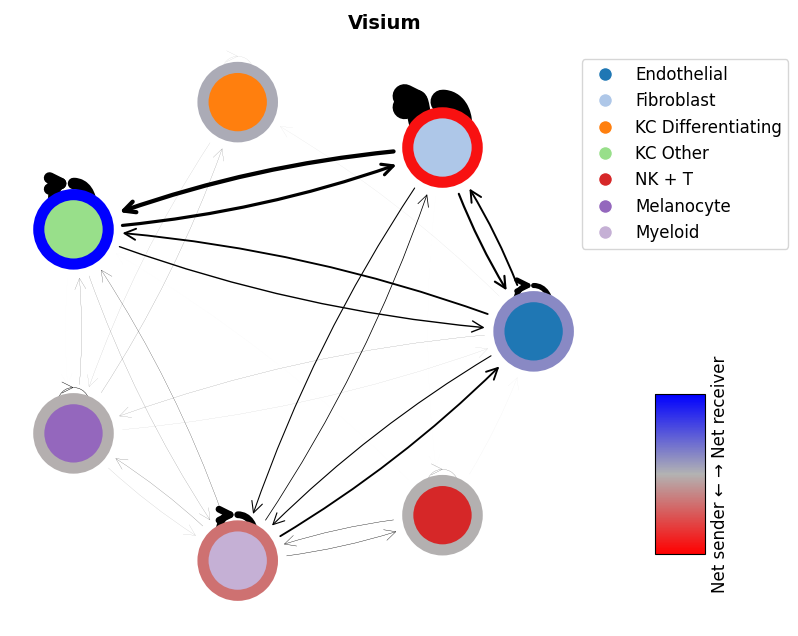

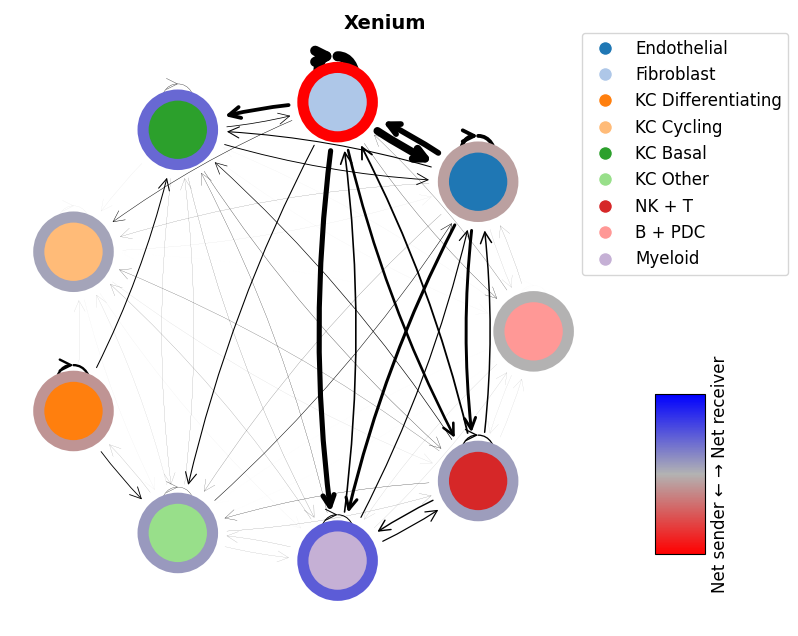

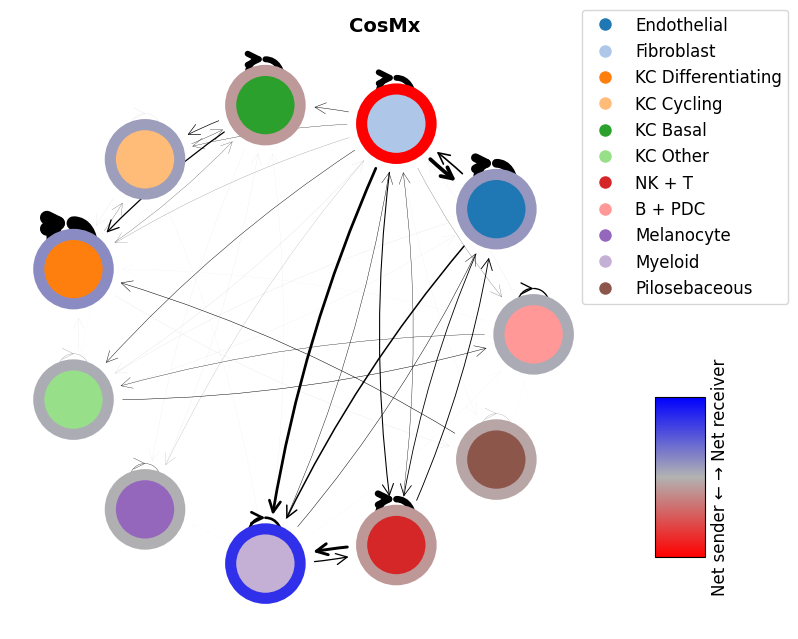

In [7]:
mmcci.plt.network_plot(visium.assays['filtered']['overall'], node_colors=colors, title='Visium')
mmcci.plt.network_plot(xenium.assays['filtered']['overall'], node_colors=colors, title='Xenium')
mmcci.plt.network_plot(cosmx.assays['filtered']['overall'], node_colors=colors, title='CosMx')

Finally, we can integrate each of these together to get a complete integrated network

Integrating p values: 100%|██████████| 1540/1540 [00:27<00:00, 55.03it/s]


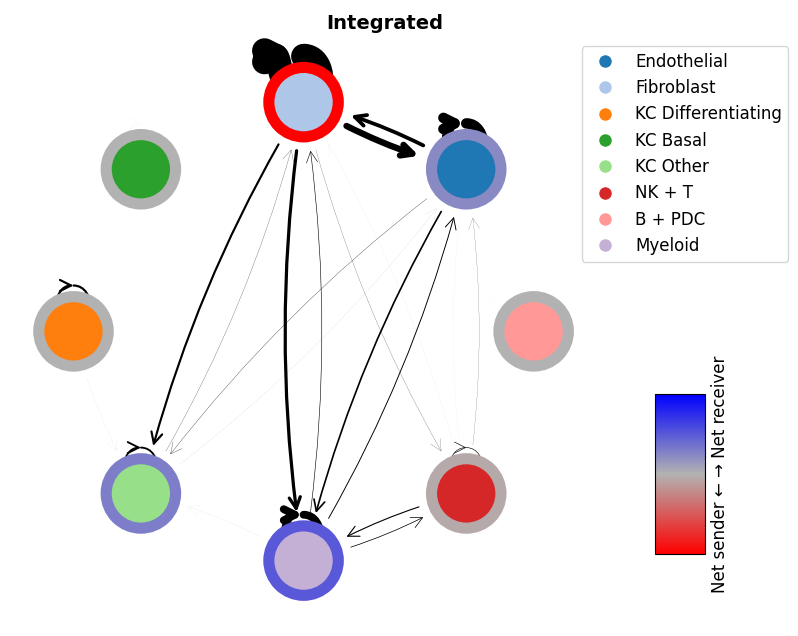

In [8]:
scale_factors = mmcci.it.calc_scale_factors([visium, xenium, cosmx])

visium = visium.scale(scale_factors['visium'])
xenium = xenium.scale(scale_factors['xenium'])
cosmx = cosmx.scale(scale_factors['cosmx'])

integrated = mmcci.it.lr_integration([visium, xenium, cosmx], method='>=50%')
integrated = integrated.filter_by_p_vals().calc_overall(assay='filtered')

mmcci.plt.network_plot(integrated.assays['filtered']['overall'], node_colors=colors, title='Integrated')

#### 3. Integrate by patient

We use the same normalised CCI results as before but integrate by patient now

In [9]:
# Define the samples that each patient has

patient_1 = [visium_samples[3], cosmx_samples[0]]
patient_2 = [visium_samples[1], cosmx_samples[1], cosmx_samples[2]]
patient_3 = [visium_samples[0], cosmx_samples[3], cosmx_samples[4], cosmx_samples[5]]
patient_4 = [visium_samples[2], cosmx_samples[6], cosmx_samples[7]]

In [10]:
patient_1_integrated = mmcci.it.lr_integration(patient_1, method='>=50%', assay='scaled')
patient_2_integrated = mmcci.it.lr_integration(patient_2, method='>=50%', assay='scaled')
patient_3_integrated = mmcci.it.lr_integration(patient_3, method='>=50%', assay='scaled')
patient_4_integrated = mmcci.it.lr_integration(patient_4, method='>=50%', assay='scaled')

Integrating p values: 100%|██████████| 645/645 [00:13<00:00, 48.09it/s]


In [11]:
patient_1_integrated = patient_1_integrated.filter_by_p_vals().calc_overall(assay='filtered')
patient_2_integrated = patient_2_integrated.filter_by_p_vals().calc_overall(assay='filtered')
patient_3_integrated = patient_3_integrated.filter_by_p_vals().calc_overall(assay='filtered')
patient_4_integrated = patient_4_integrated.filter_by_p_vals().calc_overall(assay='filtered')

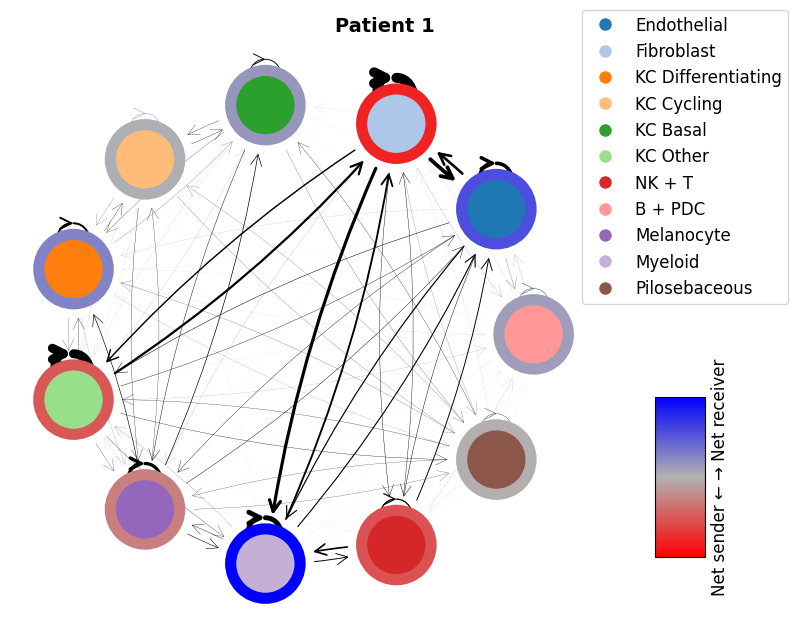

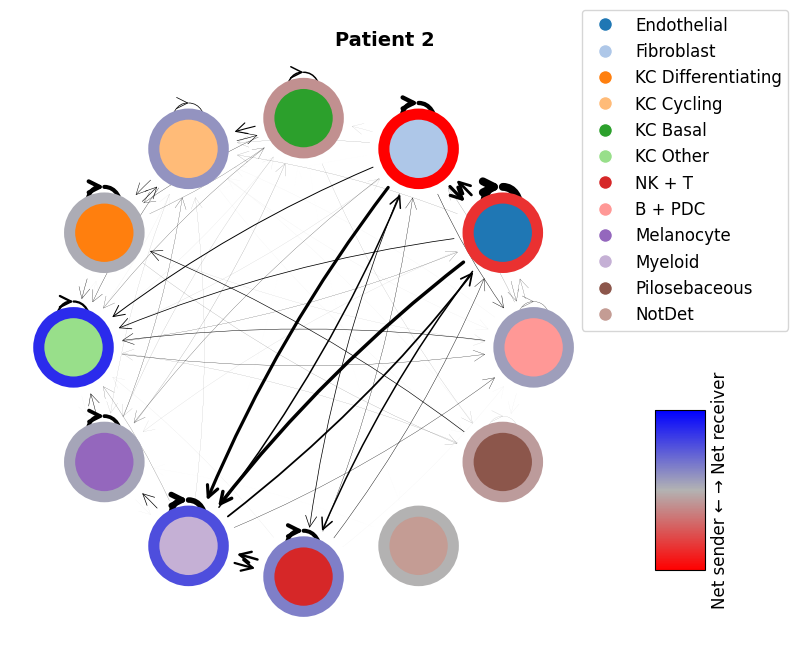

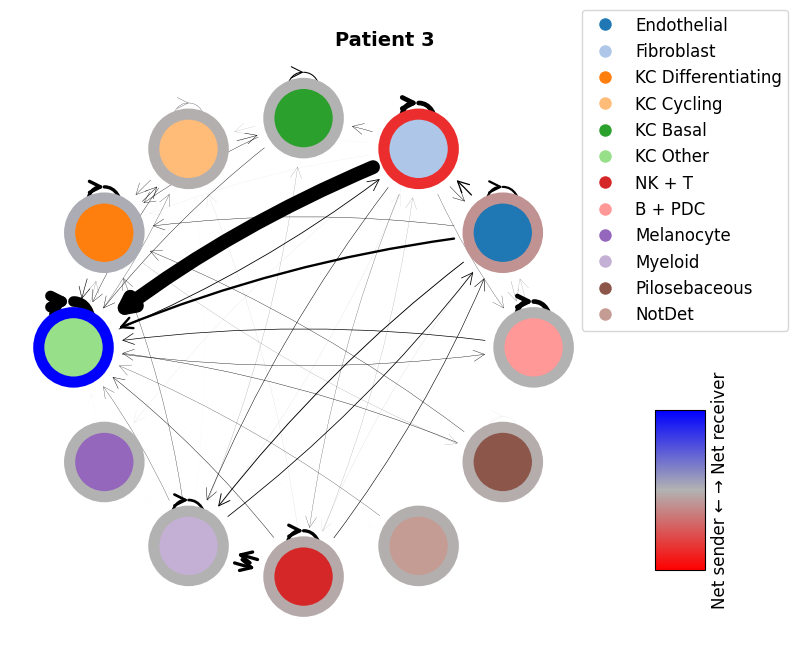

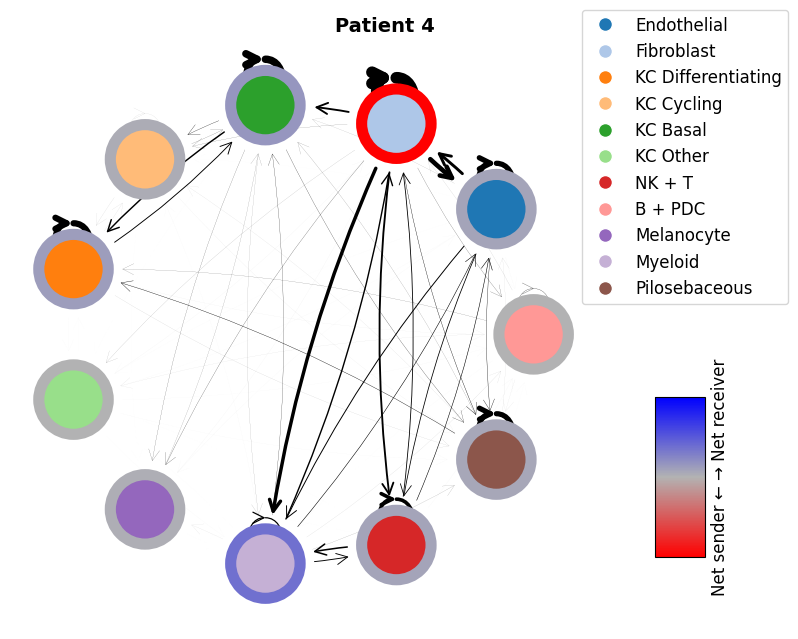

In [12]:
mmcci.plt.network_plot(patient_1_integrated.assays['filtered']['overall'], node_colors=colors, title='Patient 1')
mmcci.plt.network_plot(patient_2_integrated.assays['filtered']['overall'], node_colors=colors, title='Patient 2')
mmcci.plt.network_plot(patient_3_integrated.assays['filtered']['overall'], node_colors=colors, title='Patient 3')
mmcci.plt.network_plot(patient_4_integrated.assays['filtered']['overall'], node_colors=colors, title='Patient 4')

## **Analysis**

Here we will have a look deeper into some specific interactions relevant to the disease

#### Get LR pairs and pathways from fibroblasts to endothelial cells for each patient

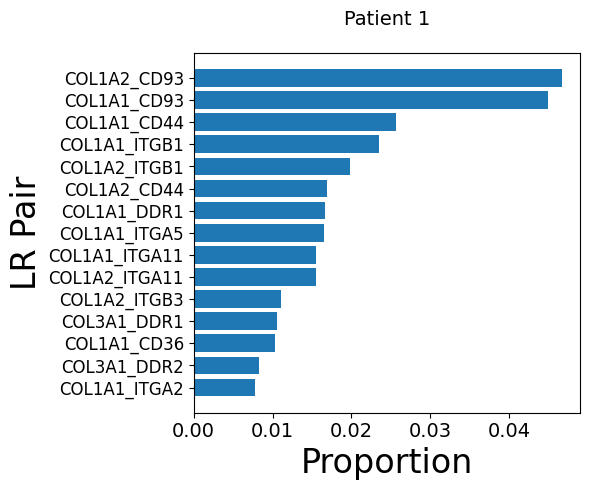

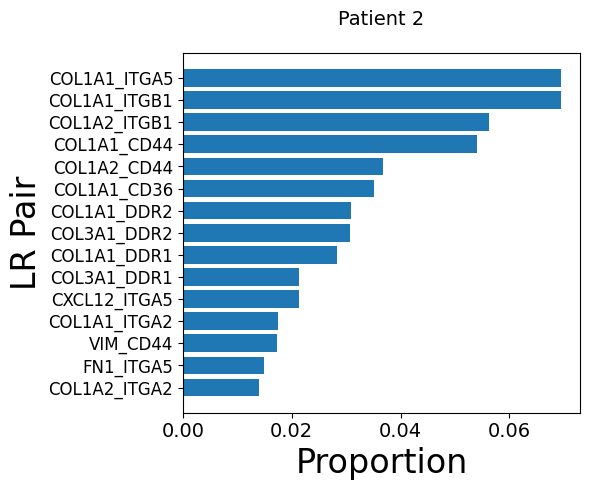

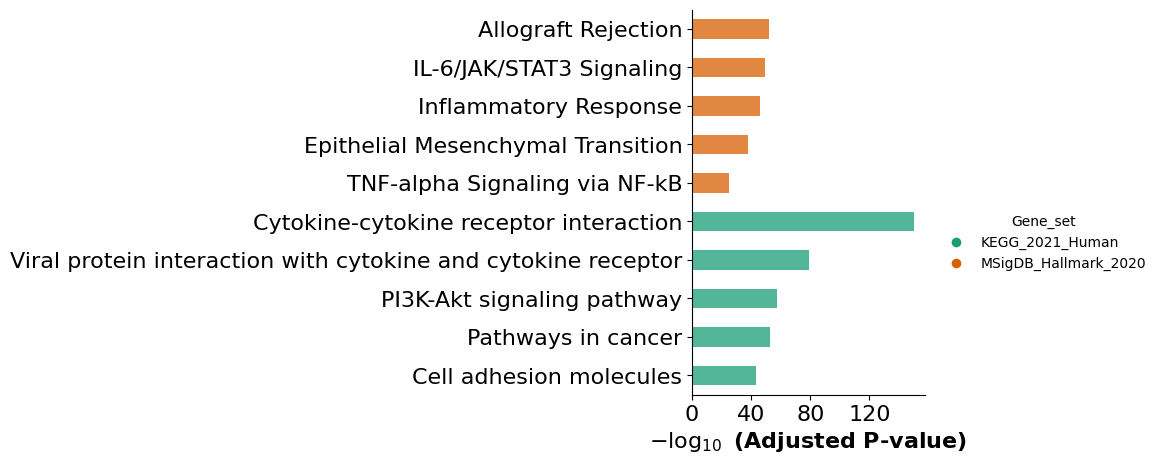

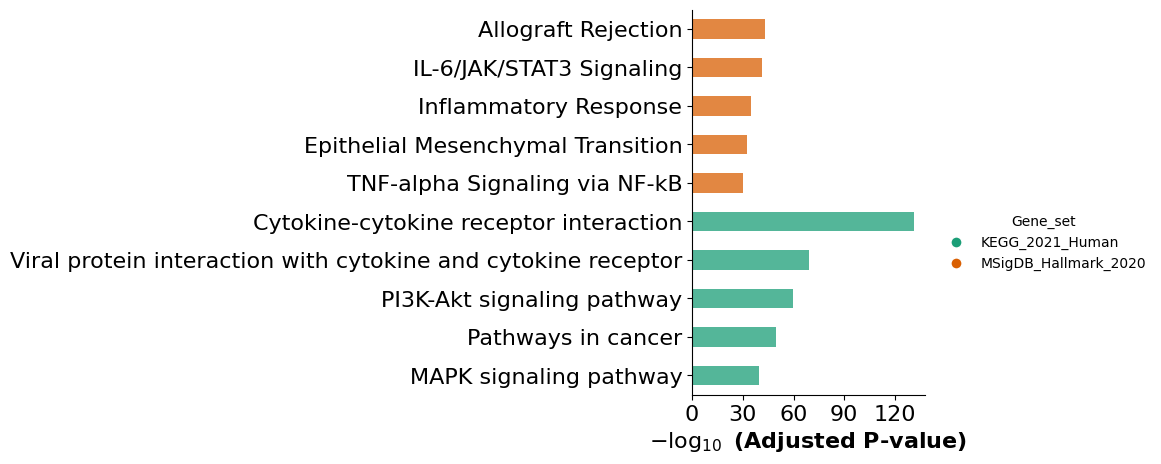

In [13]:
mmcci.plt.lrs_per_celltype(patient_1_integrated, "Fibroblast", "Endothelial", title='Patient 1')
mmcci.plt.lrs_per_celltype(patient_2_integrated, "Fibroblast", "Endothelial", title='Patient 2')
mmcci.an.run_gsea(patient_1_integrated, lrs=patient_1_integrated.get_lr_proportions("Fibroblast", "Endothelial", assay='filtered'), return_results=False)
mmcci.an.run_gsea(patient_2_integrated, lrs=patient_2_integrated.get_lr_proportions("Fibroblast", "Endothelial", assay='filtered'), return_results=False)